**0. Installing Dependencies**

In [35]:
#Dependencies
%pip install openpyxl matplotlib pandas darts statsmodels -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
total = 29000

**1. Retrieving Data**

In [37]:
import pandas as pd
file_path = '../../Data/EnergieUebersichtCH-2024.xlsx' 
xls = pd.ExcelFile(file_path)
#Dataframe in this case in the 3rd sheet Zeitreihen0h15
df = pd.read_excel(xls, sheet_name='Zeitreihen0h15', header=1, nrows=total)
print(df.columns)


Index(['Zeitstempel', 'kWh', 'kWh.1', 'kWh.2', 'kWh.3', 'kWh.4', 'kWh.5',
       'kWh.6', 'kWh.7', 'kWh.8', 'kWh.9', 'kWh.10', 'kWh.11', 'kWh.12',
       'kWh.13', 'kWh.14', 'kWh.15', 'kWh.16', 'kWh.17', 'kWh.18', 'kWh.19',
       'Euro/MWh', 'Euro/MWh.1', 'Euro/MWh.2', 'Euro/MWh.3', 'kWh.20',
       'kWh.21', 'kWh.22', 'kWh.23', 'kWh.24', 'kWh.25', 'kWh.26', 'kWh.27',
       'kWh.28', 'kWh.29', 'kWh.30', 'kWh.31', 'kWh.32', 'kWh.33', 'kWh.34',
       'kWh.35', 'kWh.36', 'kWh.37', 'kWh.38', 'kWh.39', 'kWh.40', 'kWh.41',
       'kWh.42', 'kWh.43', 'kWh.44', 'kWh.45', 'kWh.46', 'kWh.47', 'kWh.48',
       'kWh.49', 'kWh.50', 'kWh.51', 'kWh.52', 'kWh.53', 'kWh.54', 'kWh.55',
       'kWh.56', 'kWh.57', 'kWh.58', 'kWh.59'],
      dtype='object')


1.1 Aggregate Data by day

In [38]:
df['Zeitstempel'] = pd.to_datetime(
    df['Zeitstempel'],
    format='%d.%m.%Y %H:%M',   
    dayfirst=True,            
    errors='raise'            
)


In [39]:
df = df.set_index('Zeitstempel')
df = df.resample('7D').sum()
df = df[:-1]

Recalculate total by 24h

In [40]:
total = int ((total / 96) -1) 
print(total)

301


In [41]:
time_index = df.index

**2. Data variables / potential parameters** 

**Pre-processing step** Renaming column names to be clear

In [42]:
column_mapping = { 
    'kWh': 'Total Energy Consumed by End Users (kWh)',
    'kWh.1': 'Total Energy Production (kWh)',
    'kWh.2': 'Total Energy Consumption (kWh)',
    'kWh.3': 'Net Outflow (kWh)',
    'kWh.4': 'Grid Feed-In (kWh)',
    'kWh.5': 'Positive Secondary Control Energy (kWh)',
    'kWh.6': 'Negative Secondary Control Energy (kWh)',
    'kWh.7': 'Positive Tertiary Control Energy (kWh)',
    'kWh.8': 'Negative Tertiary Control Energy (kWh)'
}

df.rename(columns=column_mapping, inplace=True)

The goal is to predict the next element of the Total Energy Consumption columb:

In [43]:
energy_consumption_data = df['Total Energy Consumption (kWh)'].dropna().values

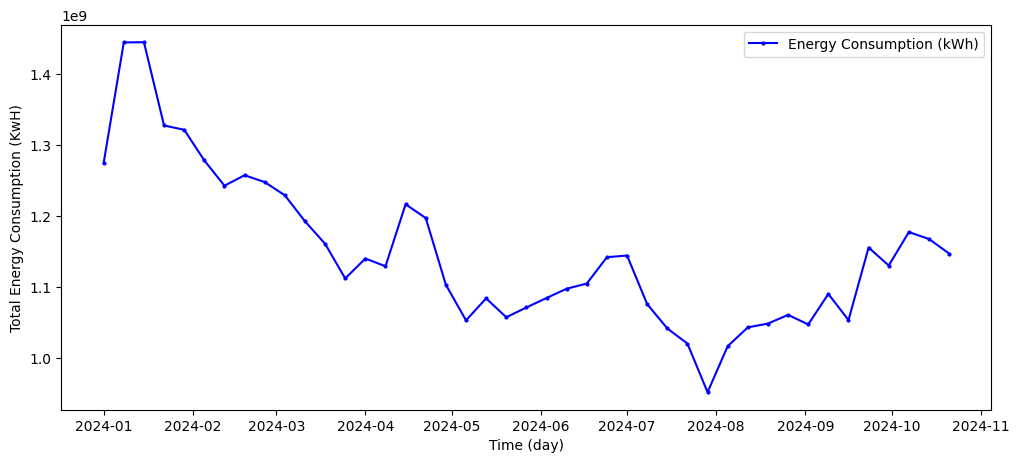

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
plt.plot(time_index, energy_consumption_data, label="Energy Consumption (kWh)", color='blue', marker='o', markersize=2)
plt.xlabel('Time (day)')
plt.ylabel('Total Energy Consumption (KwH)')
plt.plot(range(len(energy_consumption_data), len(energy_consumption_data)))
plt.legend()
plt.show()

choose how many last values to rely on: here =5

Trouver tout les variables très corrolées

I'm going to compare forecast with actual data for the same rows

**III: Time Series Analysis**

**III. 1. Stationarity of my Time Series**

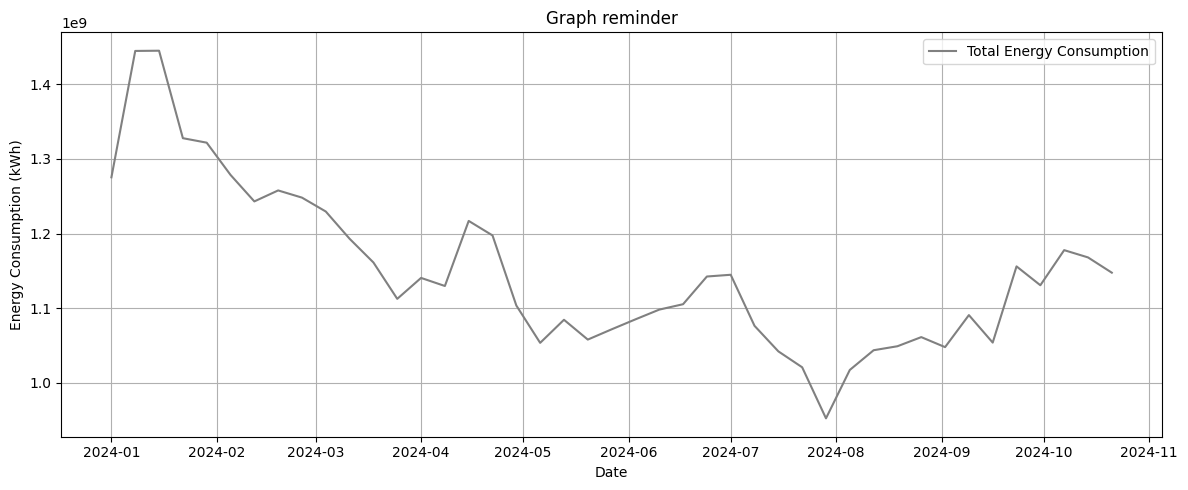

In [45]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'], label='Total Energy Consumption', color='gray')
ax.set_title('Graph reminder')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

To-do: forecast par semaine, dépend de swissgrid, 

Ecrire chaque concept dans le rapport

graph de xt+i - xt

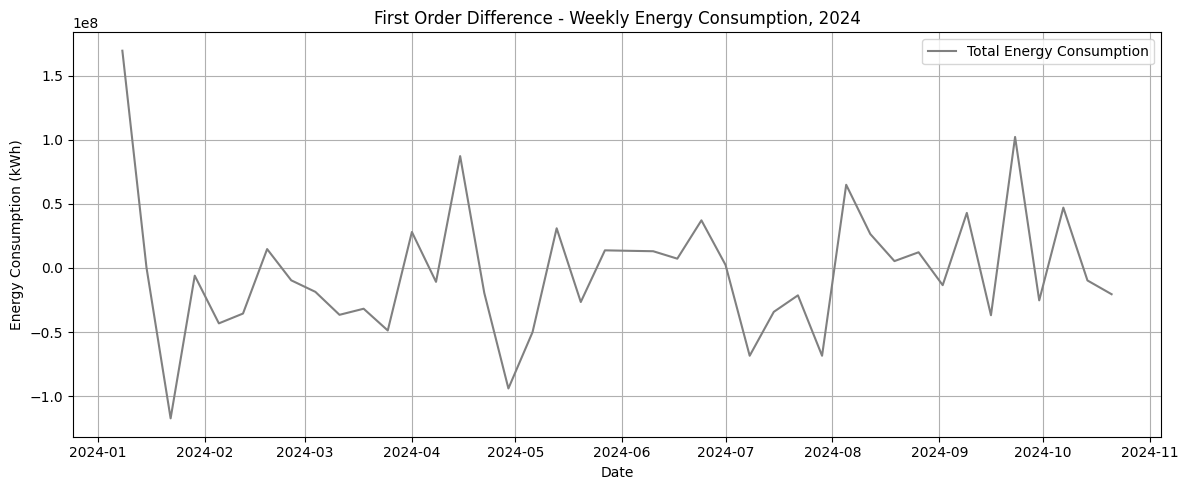

In [46]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df['Total Energy Consumption (kWh)'].diff(), label='Total Energy Consumption', color='gray')
ax.set_title('First Order Difference - Weekly Energy Consumption, 2024')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

**III. 1.a. Informal check**

**III. 1.a. i. Mean Calculation**

Calculating the mean of my time series (Total Power Consumption in the Grid)

the formula for the mean is: μ = (x₁ + x₂ + ... + xₙ) / n

In [47]:
def mean(data):
    return sum(data) / len(data)

In [48]:
print(mean(energy_consumption_data))

1148868353.907386


In [49]:
def sliced_mean_calculator(data, time_index,variance_window_size):
    means = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = mean(window_slice)
        means.append(var)
        time_indices.append(time_index[i + variance_window_size - 1])
    return means, time_indices

In [50]:
mean_window_size = len(energy_consumption_data) // 10

In [51]:
means, time_indices = sliced_mean_calculator(energy_consumption_data,time_index, mean_window_size)

Plotting Mean over time

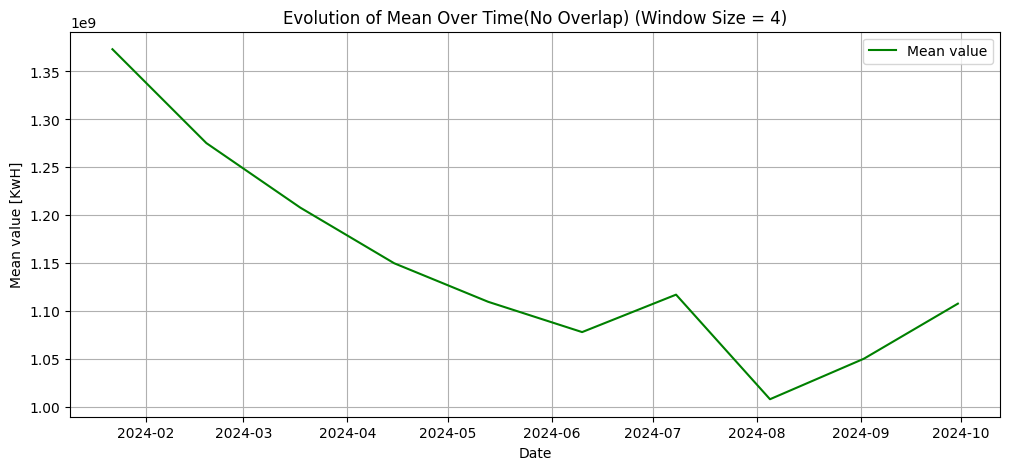

In [52]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', label='Mean value')
plt.xlabel('Date')
plt.ylabel('Mean value [KwH]')
plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
plt.grid(True)
plt.legend()
plt.show()

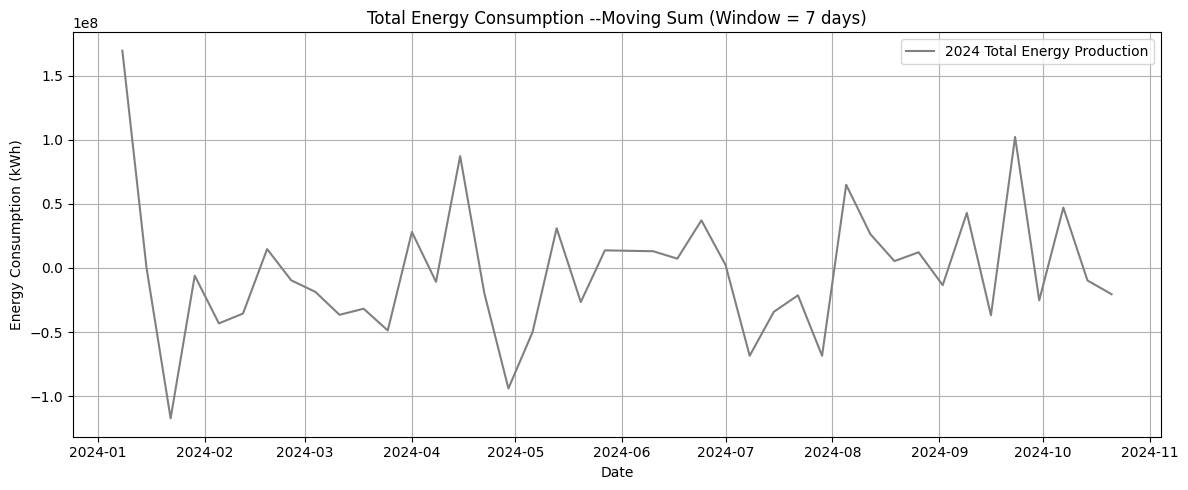

In [53]:
year = 2024
month = 5
df_summed = df.resample('7D').sum()
df_month = df_summed[(df_summed.index.year == year)]
df_diff = df_month['Total Energy Consumption (kWh)'].diff()
# Plot
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_diff, label=f'{year} Total Energy Production', color='gray')
ax.set_title(f'Total Energy Consumption --Moving Sum (Window = 7 days)')
ax.set_xlabel('Date')
ax.set_ylabel('Energy Consumption (kWh)')
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

In [54]:
means, time_indices = sliced_mean_calculator(df_diff,time_index, mean_window_size)

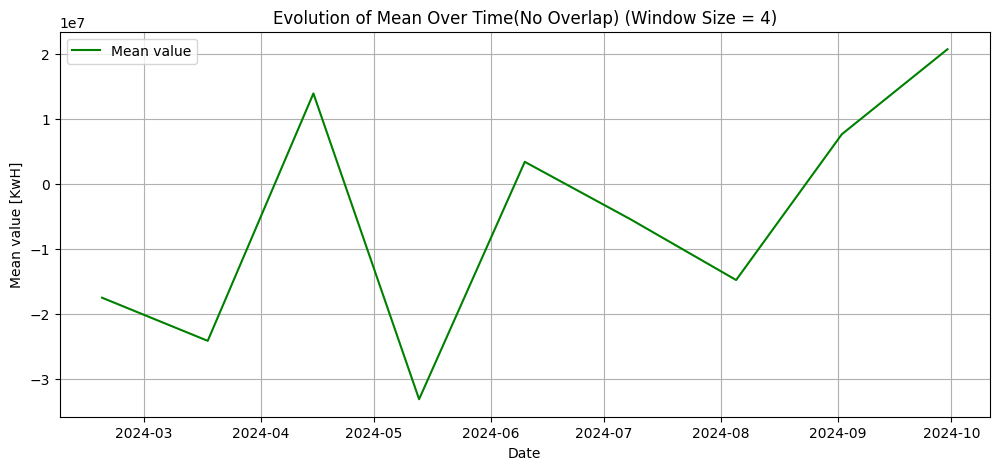

In [55]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, means, color='green', label='Mean value')
plt.xlabel('Date')
plt.ylabel('Mean value [KwH]')
plt.title(f'Evolution of Mean Over Time(No Overlap) (Window Size = {mean_window_size})')
plt.grid(True)
plt.legend()
plt.show()

**III. 1.a. ii. Variance Calculation**

Calculating Variance:

Variance = 1/n sum(xi- mean)**2

In [56]:
def variance(data):
    mean_value = mean(data)
    variance = sum((x - mean_value)**2 for x in data) / len(data)
    return variance

In [57]:
print(variance(energy_consumption_data))

1.1592750113141402e+16


Plotting variance over time

In [58]:
total_length =  len(energy_consumption_data)
variance_window_size = total_length // 10

In [59]:
print(variance_window_size)

4


Defining variance, time arrays

In [60]:
def sliced_variances_calculator(data, time_index,variance_window_size):
    variances = []
    time_indices = []
    
    for i in range(0, len(data) - variance_window_size + 1, variance_window_size):  
        window_slice = data[i:i + variance_window_size]
        var = variance(window_slice)
        variances.append(var)
        time_indices.append(time_index[i + variance_window_size - 1]) 
    return variances, time_indices


In [61]:
variances, time_indices = sliced_variances_calculator(energy_consumption_data,time_index, variance_window_size)

In [62]:
print(variances, time_indices)

[5480720091757872.0, 880126795337172.1, 1122922580822733.0, 1598261717688811.2, 2886938912898864.0, 224218040611145.7, 802603661206975.5, 1128111391295042.8, 42918319592212.88, 1513456323661910.5] [Timestamp('2024-01-22 00:00:00'), Timestamp('2024-02-19 00:00:00'), Timestamp('2024-03-18 00:00:00'), Timestamp('2024-04-15 00:00:00'), Timestamp('2024-05-13 00:00:00'), Timestamp('2024-06-10 00:00:00'), Timestamp('2024-07-08 00:00:00'), Timestamp('2024-08-05 00:00:00'), Timestamp('2024-09-02 00:00:00'), Timestamp('2024-09-30 00:00:00')]


Plotting Variance over time

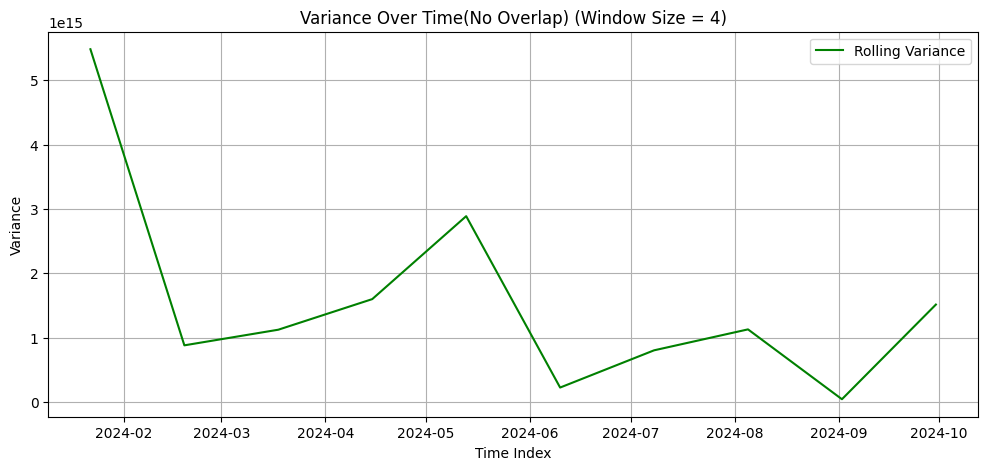

In [63]:
plt.figure(figsize=(12, 5))
plt.plot(time_indices, variances, color='green', label='Rolling Variance')
plt.xlabel('Time Index')
plt.ylabel('Variance')
plt.title(f'Variance Over Time(No Overlap) (Window Size = {variance_window_size})')
plt.grid(True)
plt.legend()
plt.show()

**III. 1.a. iii. Autocorrelation Calculation**

In [64]:
from statsmodels.tsa.stattools import acf

autocorrelation function (ACF) at lag k, for k ≥ 0, of the time series is defined by
rk = sk/ s0 where sk is the autocovariance at lag k

In [70]:
alpha = 0.05
confint = 1 - alpha
nlags = 40

In [66]:
import numpy as np

In [67]:
def check_autocorrelation(data, nlags=10, alpha=0.05):
    data = np.asarray(data)
    acf_vals, _ = acf(data, nlags=nlags, alpha=alpha, fft=False) 
    return acf_vals


In [68]:
acf_vals = check_autocorrelation(energy_consumption_data, nlags=nlags)

In [71]:
print(f"High Autocorrelation defined as {1 - alpha}")
for lag in range(1, nlags + 1):
    print(f"lag {lag:2d} → ACF = {acf_vals[lag]: .4f}")

High Autocorrelation defined as 0.95
lag  1 → ACF =  0.8755
lag  2 → ACF =  0.7131
lag  3 → ACF =  0.5690
lag  4 → ACF =  0.4682
lag  5 → ACF =  0.3998
lag  6 → ACF =  0.3648
lag  7 → ACF =  0.3159
lag  8 → ACF =  0.2358
lag  9 → ACF =  0.1694
lag 10 → ACF =  0.1048
lag 11 → ACF =  0.0582
lag 12 → ACF =  0.0384
lag 13 → ACF =  0.0247
lag 14 → ACF = -0.0010
lag 15 → ACF = -0.0549
lag 16 → ACF = -0.1294
lag 17 → ACF = -0.1703
lag 18 → ACF = -0.1875
lag 19 → ACF = -0.2058
lag 20 → ACF = -0.2265
lag 21 → ACF = -0.2242
lag 22 → ACF = -0.2235
lag 23 → ACF = -0.2135
lag 24 → ACF = -0.2229
lag 25 → ACF = -0.2603
lag 26 → ACF = -0.3382
lag 27 → ACF = -0.3777
lag 28 → ACF = -0.3978
lag 29 → ACF = -0.3749
lag 30 → ACF = -0.3136
lag 31 → ACF = -0.2509
lag 32 → ACF = -0.2135
lag 33 → ACF = -0.1833
lag 34 → ACF = -0.1441
lag 35 → ACF = -0.1098
lag 36 → ACF = -0.0589
lag 37 → ACF = -0.0142
lag 38 → ACF =  0.0145
lag 39 → ACF =  0.0233
lag 40 → ACF =  0.0178


Setting axis at 0

In [72]:
acf_series = TimeSeries.from_values(acf_vals[1:])
plt.figure(figsize=(10, 6))
acf_series.plot(label="ACF")
plt.title("Autocorrelation Function (ACF)")
plt.xlabel("Lag")
plt.ylabel("ACF value between value x and x - lag")
plt.legend(loc="upper right")
plt.show()

NameError: name 'TimeSeries' is not defined

If (Xt) is strictly stationary, then:

(i) ... that is the mean is constant.


(ii) ... that is the covariance is invariant  (source: ETHZ, Time Series Analysis 2022)

**III. 1.a. Formal check**

ADF method checks if time series is stationnary

Importing ADF Method

ADF a statistical method used to determine if a time series is stationary. It helps identify whether a series has a unit root, which is a formal indication of non-stationarity. A significant p-value (typically less than 0.05) suggests stationarity (source: Google)

In [ ]:
from statsmodels.tsa.stattools import adfuller


In [ ]:
significance_level=0.05

adfuller returns among other things adf_statistic and p_value, adf_statistic is 

In [ ]:
def adf_test(data, significance_level):
    result = adfuller(data)
    p_value = result[1]
    print(f'p-value: {p_value}')
    if p_value < significance_level:
        print("Conclusion: Time Series stationary.")
    else:
        print("Conclusion: Time series non-stationary.")

In [ ]:
adf_test(energy_consumption_data, significance_level)

p-value: 0.020836571178422626
Conclusion: Time Series stationary.


Akaike Information Criterion:

AIC=2k−2ln(L)
where:
k = number of parameters in the model
L = maximum value of the likelihood function for the model

Bayesian Information Criterion: heavier penalty for models with more parameters

In [ ]:
from darts.utils.statistics import (
    remove_trend,
    stationarity_test_adf,
    stationarity_test_kpss,
    plot_acf,
    plot_pacf,
    plot_residuals_analysis,
    check_seasonality,
    extract_trend_and_seasonality,
    remove_from_series
)
from darts.utils.utils      import ModelMode, SeasonalityMode

2. seasonality check


expliquez comment seasonality marche, comment trending marche, pourquoi on n'a pas utilité IGD, 

In [ ]:
has_season, m = check_seasonality(time_series, m=None, max_lag=30, alpha=0.05)
print(f"Has seasonality? {has_season}, period = {m} days")

Has seasonality? True, period = 7 days


Extracting Trend and Seasonality

I'm going to use a DARTS function

method (str) – The method to be used to decompose the series. - “naive” : Seasonal decomposition using moving averages [1]. - “STL” : Season-Trend decomposition using LOESS [2]. Only compatible with ADDITIVE model type. - “MSTL” : Season-Trend decomposition using LOESS with multiple seasonalities [3]. Only compatible with ADDITIVE model type.


comprendre les deux

2. (a) “naive” moving-average decomposition (additive)

In [ ]:
trend_naive, seas_naive = extract_trend_and_seasonality(
    time_series,
    freq=m,
    model= ModelMode.ADDITIVE,
    method='naive'
)

2. (b) STL decomposition

In [ ]:
trend, seasonal = extract_trend_and_seasonality(
    time_series,
    freq=m,
    model=ModelMode.ADDITIVE,
    method='STL',
    robust=True 
)

Plotting STL results

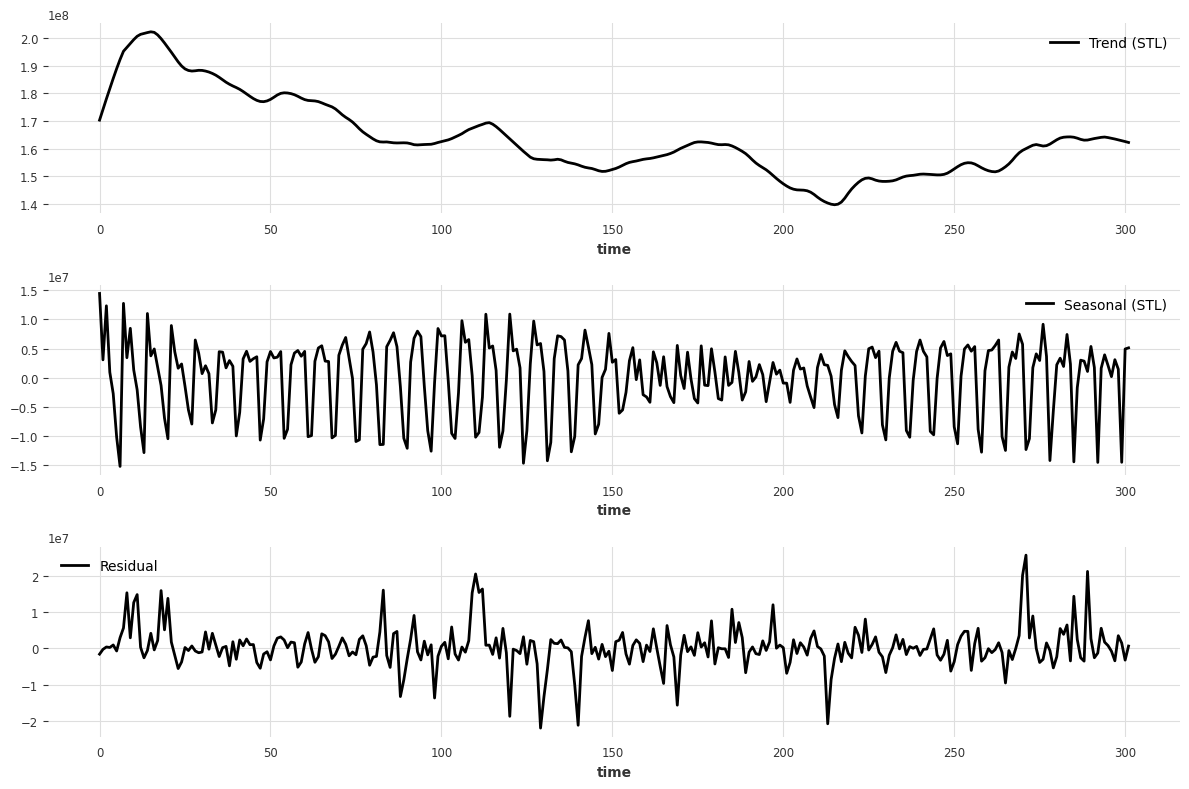

In [ ]:
plt.figure(figsize=(12, 8))
ax = plt.subplot(311); trend.plot(label='Trend (STL)', ax=ax)
ax = plt.subplot(312); seasonal.plot(label='Seasonal (STL)', ax=ax)
ax = plt.subplot(313); (time_series - trend - seasonal).plot(label='Residual', ax=ax)
plt.tight_layout()
plt.show()

Check si il y a plusieurs fréquences, lequels, c'est quoi leurs amplitudes, check residual stat

Removing seasonality and trend

Removing seasonality

In [ ]:
ts_deseason = remove_from_series(time_series, seasonal, SeasonalityMode.ADDITIVE)


Removing trend

In [ ]:
ts_detrended = remove_from_series(ts_deseason, trend, ModelMode.ADDITIVE)

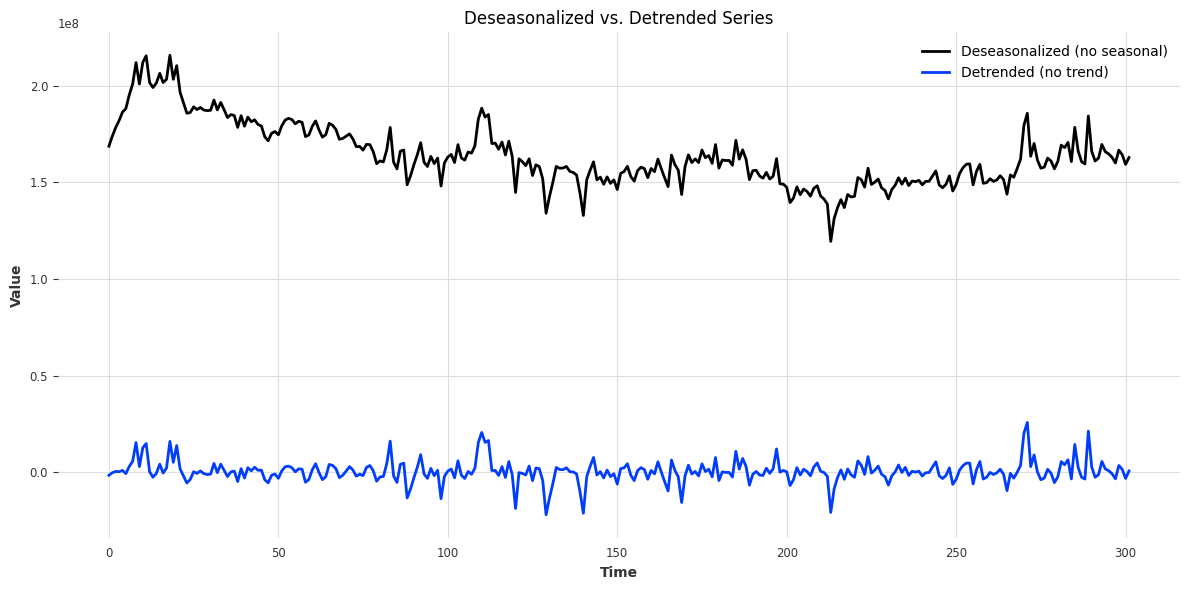

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
ax = plt.gca()
ts_deseason.plot(label='Deseasonalized (no seasonal)', ax=ax)
ts_detrended.plot(label='Detrended (no trend)', ax=ax)

plt.title('Deseasonalized vs. Detrended Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

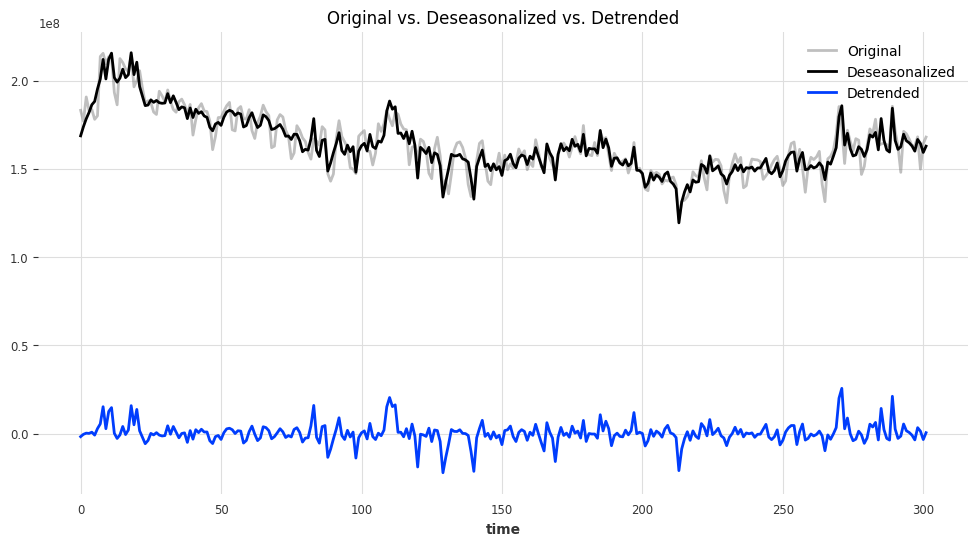

In [ ]:
plt.figure(figsize=(12,6))
ax = plt.gca()
time_series.plot(label='Original',            ax=ax, color='gray', alpha=0.5)
ts_deseason.plot(label='Deseasonalized', ax=ax)
ts_detrended.plot(label='Detrended',     ax=ax)
plt.title('Original vs. Deseasonalized vs. Detrended')
plt.legend(); plt.show()

We're going to generate a darts time_series version of the data

In [ ]:
from darts import TimeSeries
time_series = TimeSeries.from_values(energy_consumption_data)


Train an AutoRegression (AR) Model, using ARModel from module 8

Splitting data to 90, 10% training testing

In [ ]:
train, test = time_series.split_before(0.9)  

Initialiser notre model

In [ ]:
p = 10

In [ ]:
from darts.models import ARIMA
arima_model = ARIMA(p)
arima_model.fit(train)

ARIMA(p=10, d=1, q=0, seasonal_order=(0, 0, 0, 0), trend=None, random_state=None, add_encoders=None)

Prediction of test data

We use .predict to forecast the next `len(test)` values

I'm going to use statsmodels for AR

In [ ]:
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
lags = 10
model = AutoReg(energy_consumption_data, lags)
model_fitted = model.fit()   
print(model_fitted.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  302
Model:                    AutoReg(10)   Log Likelihood               -5020.900
Method:               Conditional MLE   S.D. of innovations        7102254.434
Date:                Mon, 19 May 2025   AIC                          10065.799
Time:                        17:44:06   BIC                          10109.920
Sample:                            10   HQIC                         10083.472
                                  302                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.108e+07   4.51e+06      2.458      0.014    2.24e+06    1.99e+07
y.L1           0.6620      0.058     11.362      0.000       0.548       0.776
y.L2          -0.0963      0.070     -1.379      0.1

In [ ]:
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)
print(forecast)


[1.67589211e+08 1.61732904e+08 1.65782626e+08 1.62561942e+08
 1.57585097e+08 1.62367557e+08 1.64806795e+08 1.64255041e+08
 1.62637227e+08 1.64212009e+08 1.61413924e+08 1.59973907e+08
 1.61596087e+08 1.62930171e+08 1.62525837e+08 1.62475351e+08
 1.62716398e+08 1.61206178e+08 1.60587554e+08 1.61198759e+08
 1.61755018e+08 1.61646530e+08 1.61856125e+08 1.61749411e+08
 1.60992252e+08 1.60647968e+08 1.60863260e+08 1.61048593e+08
 1.61080027e+08 1.61234016e+08 1.61108812e+08 1.60720204e+08
 1.60514654e+08 1.60557166e+08 1.60601606e+08 1.60653992e+08
 1.60734782e+08 1.60648492e+08 1.60442175e+08 1.60314251e+08
 1.60289880e+08 1.60286433e+08 1.60319851e+08 1.60354887e+08
 1.60300520e+08 1.60187355e+08 1.60103848e+08 1.60061937e+08
 1.60043321e+08 1.60055566e+08 1.60065874e+08 1.60030819e+08
 1.59965865e+08 1.59909149e+08 1.59868918e+08 1.59846739e+08
 1.59845119e+08 1.59842907e+08 1.59818716e+08 1.59778934e+08
 1.59739321e+08 1.59706173e+08 1.59684855e+08 1.59676183e+08
 1.59668220e+08 1.596501

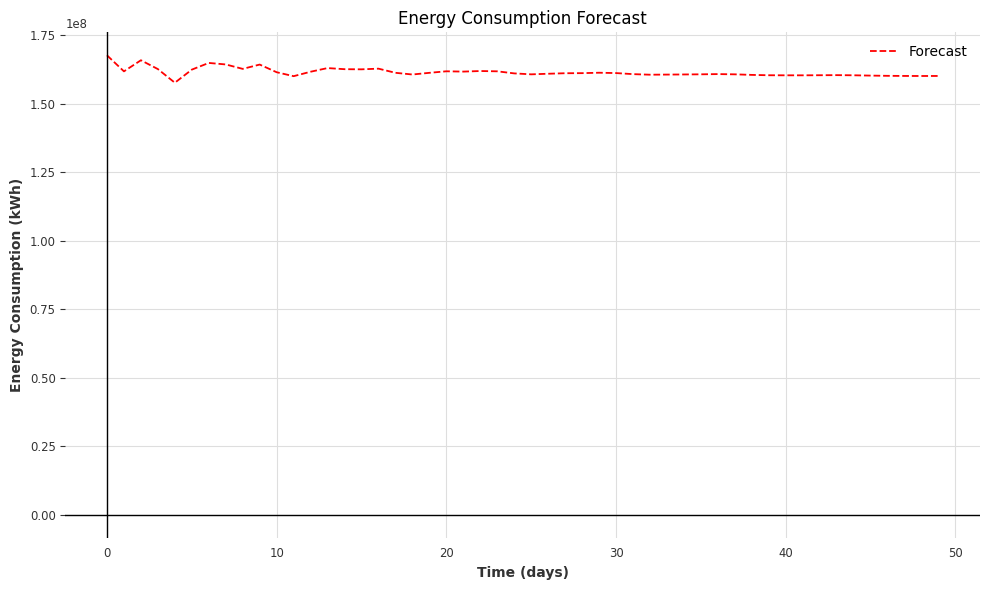

In [ ]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Going to create a combined dataset: 300 last actual points and 50 forecasted points


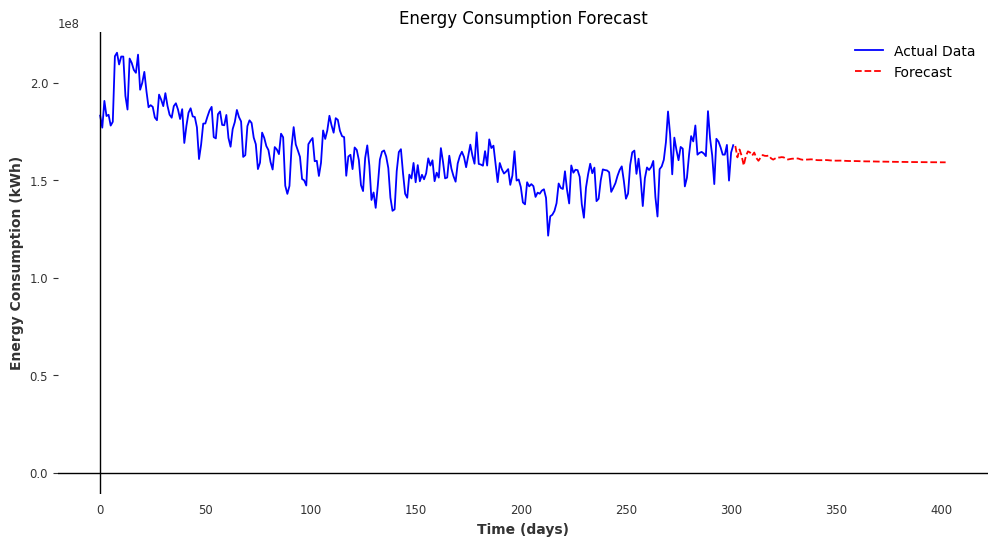

In [ ]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


on teste avec lag = 30

In [ ]:
model = AutoReg(energy_consumption_data, lags=30)  
forecast = model_fitted.predict(start=len(energy_consumption_data), end=len(energy_consumption_data) + 100)

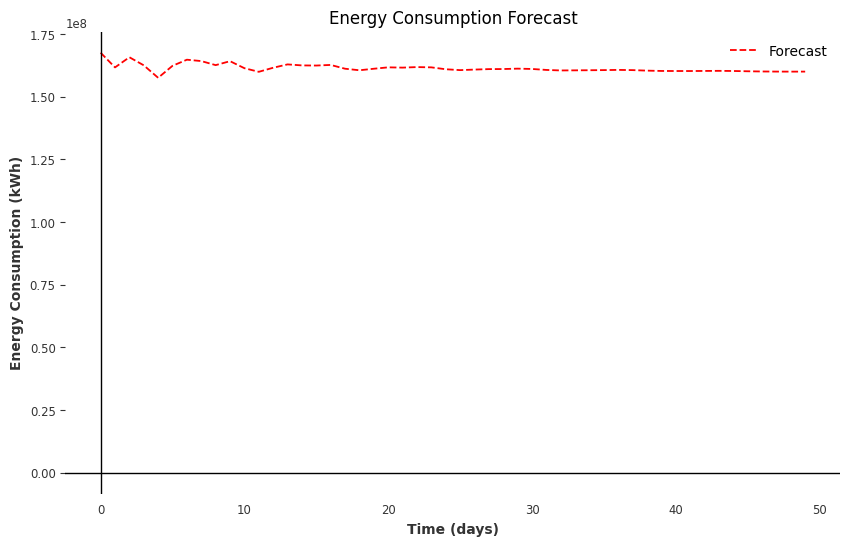

In [ ]:
import numpy as np
forecast_periods = 50
plt.figure(figsize=(10, 6))
plt.plot(forecast[:forecast_periods], label='Forecast', color='red', linestyle='--')

plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()

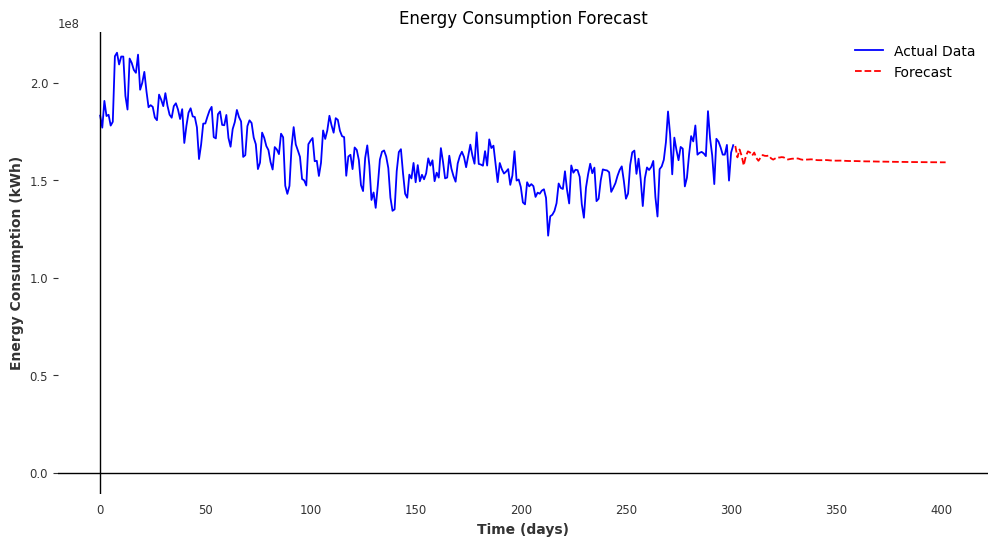

In [ ]:
combined_data = np.concatenate((energy_consumption_data, forecast))

plt.figure(figsize=(12, 6))

plt.plot(energy_consumption_data, label='Actual Data', color='blue')
plt.plot(np.arange(len(energy_consumption_data), len(combined_data)), forecast, label='Forecast', color='red', linestyle='--')
plt.ylabel('Energy Consumption (kWh)')
plt.title('Energy Consumption Forecast')
plt.xlabel('Time (days)')
plt.axhline(0, color='black', linewidth=1)
plt.axvline(0, color='black', linewidth=1)
plt.legend()
plt.grid()
plt.show()


Vector Auto-regression

Je vais utiliser statsmodels pour VAR

Data cleaning, converts everything to numeric, replacing errors with NaN

In [ ]:
print(df)

             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-01-01                               1.361635e+08   
2024-01-02                               1.475919e+08   
2024-01-03                               1.529386e+08   
2024-01-04                               1.580906e+08   
2024-01-05                               1.654799e+08   
...                                               ...   
2024-10-24                               1.413813e+08   
2024-10-25                               1.401766e+08   
2024-10-26                               1.239567e+08   
2024-10-27                               1.170852e+08   
2024-10-28                               1.381239e+08   

             Total Energy Production (kWh)  Total Energy Consumption (kWh)  \
Zeitstempel                                                                  
2024-01-01                    1.296562e+08                    1.831487e+08   
2024-01-02              

In [ ]:
df = df.apply(pd.to_numeric, errors='coerce') 

Only going to consider first 6 rows

In [ ]:
df = df.iloc[:, :6]

In [ ]:
df_cleaned = df.dropna()

Split testing 20-80 ish

In [ ]:
test_total = int(0.2*300)

In [ ]:
train_data = df.iloc[:-test_total]  
test_data = df.iloc[-test_total:]  

Initialize VAR model

In [ ]:
from statsmodels.tsa.api import VAR
model = VAR(train_data)

In [ ]:
print(df.shape)  

(302, 6)


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)  


In [ ]:
p = 6
fitted_model = model.fit(p) 

forecast next 20%

In [ ]:
forecast = fitted_model.forecast(train_data.values[-p:], steps=test_total) 

In [ ]:
correlation_matrix = df.corr()
print(correlation_matrix)


                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                  1.000000   
Total Energy Production (kWh)                                            -0.064989   
Total Energy Consumption (kWh)                                            0.892140   
Net Outflow (kWh)                                                         0.368196   
Grid Feed-In (kWh)                                                        0.021612   
Positive Secondary Control Energy (kWh)                                   0.343144   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                      -0.064989   
Total Energy Production (kWh)                                  1.000000   
Total Energy Consumption (kWh)                                -0.195994   
Net Outflow (kWh)                                             -0.539762   
Grid Feed-In (kWh)    

In [ ]:
correlation_threshold = 0.9
high_correlation = correlation_matrix.abs() > correlation_threshold
print(high_correlation)

                                          Total Energy Consumed by End Users (kWh)  \
Total Energy Consumed by End Users (kWh)                                      True   
Total Energy Production (kWh)                                                False   
Total Energy Consumption (kWh)                                               False   
Net Outflow (kWh)                                                            False   
Grid Feed-In (kWh)                                                           False   
Positive Secondary Control Energy (kWh)                                      False   

                                          Total Energy Production (kWh)  \
Total Energy Consumed by End Users (kWh)                          False   
Total Energy Production (kWh)                                      True   
Total Energy Consumption (kWh)                                    False   
Net Outflow (kWh)                                                 False   
Grid Feed-In (kWh)    

In [ ]:
forecast_df = pd.DataFrame(forecast, index=test_data.index, columns=test_data.columns)

In [ ]:
from statsmodels.tools.eval_measures import rmse

print("Forecast:")
print(forecast_df)


Forecast:
             Total Energy Consumed by End Users (kWh)  \
Zeitstempel                                             
2024-08-30                               1.370782e+08   
2024-08-31                               1.244544e+08   
2024-09-01                               1.230497e+08   
2024-09-02                               1.290325e+08   
2024-09-03                               1.314795e+08   
2024-09-04                               1.329195e+08   
2024-09-05                               1.361297e+08   
2024-09-06                               1.335096e+08   
2024-09-07                               1.268282e+08   
2024-09-08                               1.267967e+08   
2024-09-09                               1.301474e+08   
2024-09-10                               1.312354e+08   
2024-09-11                               1.330395e+08   
2024-09-12                               1.350264e+08   
2024-09-13                               1.325797e+08   
2024-09-14           

Root mean square deviation for average difference between values predicted by a model and the actual values

In [ ]:
rmse_score = rmse(test_data, forecast_df)
print(f"RMSE: {rmse_score}")

RMSE: [10573099.53187188 29086623.00061338 11399462.00544798  3544050.47164713
 25251109.68430102   159659.02540381]


In [ ]:
def plot_actual_vs_forecasted(col):
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(test_data.index,     test_data[col],     '--', color='blue', label=f'Actual {col}')
    ax.plot(forecast_df.index, forecast_df[col], '-',  color='red',  label=f'Forecast {col}')

    ax.set_title(f'Actual vs Forecasted {col}', fontsize=16)
    ax.set_xlabel('Date', fontsize=14)
    ax.set_ylabel(col, fontsize=14)
    ax.axhline(0, color='black', linewidth=1)
    ax.axvline(test_data.index[0], color='black', linewidth=1)
    ax.grid(True)
    ax.legend(loc='upper left')
    plt.tight_layout()
    plt.show()

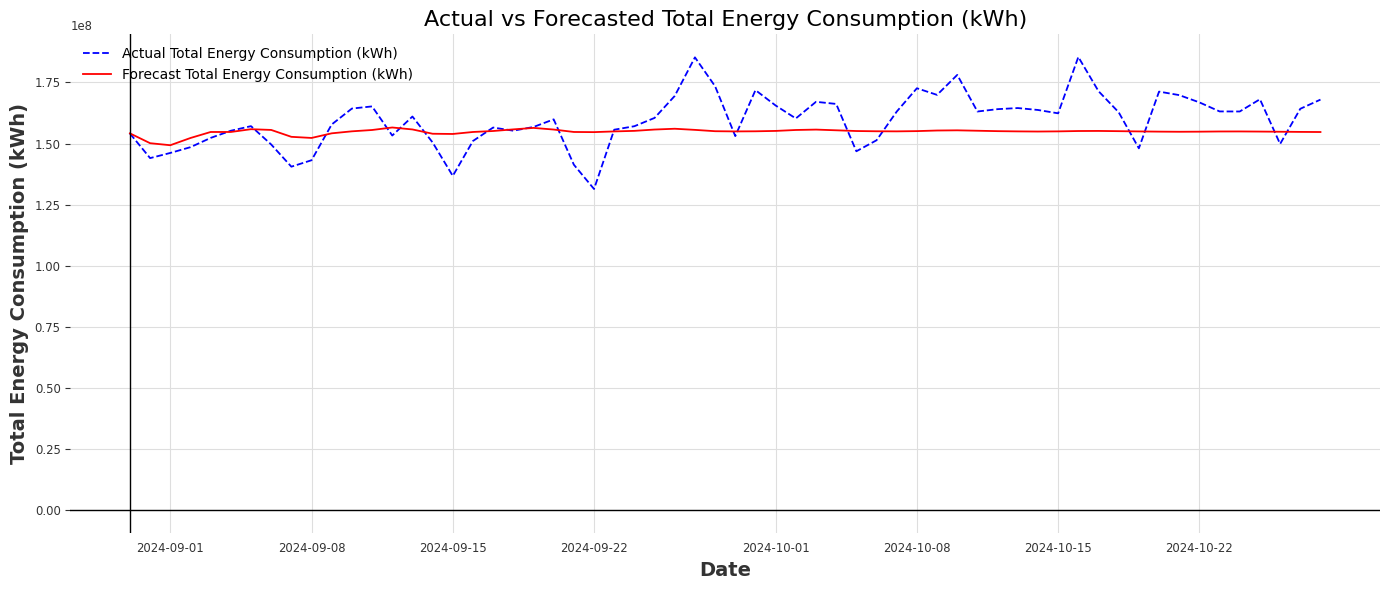

In [ ]:
plot_actual_vs_forecasted('Total Energy Consumption (kWh)')

In [ ]:
#for col in forecast_df.columns[:2]:
#    plot_actual_vs_forecasted(col)